# A Comprehensive Guide to Constructing an Exotic Derivatives Pricing Engine

**Final Report and Synthesis**

This notebook serves as the final, comprehensive report for the Exotic Derivatives Pricing Engine project. It synthesizes the theoretical foundations, architectural design, and numerical implementations into a single, reproducible document. We will present a series of case studies demonstrating the engine's capabilities, validate its results, and analyze the complex financial behaviors of exotic options.

## Part I: Setup and Configuration

First, we import the necessary libraries and the core components of our pricing engine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # Add root project dir to path

from src.exotic_engine.models.gbm import GeometricBrownianMotionProcess
from src.exotic_engine.instruments.barrier import BarrierOption
from src.exotic_engine.pricing_engines.fd_engine import FDEngine
from src.exotic_engine.analysis.greeks import GreeksCalculator

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

sns.set_style("darkgrid")

# Import all components from our engine
from src.exotic_engine.models.gbm import GeometricBrownianMotionProcess
from src.exotic_engine.instruments.european import EuropeanOption
from src.exotic_engine.instruments.asian import AsianOption
from src.exotic_engine.instruments.barrier import BarrierOption
from src.exotic_engine.instruments.bermudan import BermudanOption
from src.exotic_engine.pricing_engines.mc_engine import MonteCarloEngine
from src.exotic_engine.pricing_engines.fd_engine import FDEngine
from src.exotic_engine.pricing_engines.tree_engine import TreeEngine
from src.exotic_engine.analysis.greeks import GreeksCalculator

print("Engine components imported successfully.")

Engine components imported successfully.


## Part II: Case Study - Pricing and Cross-Validation

A key validation step is to price the same instruments using our different numerical methods and ensure the results are consistent. We will price a standard European call and a more complex up-and-out barrier call.

**Market Parameters:**
- Spot Price (S0): $100
- Strike Price (K): $100
- Time to Maturity (T): 1 year
- Risk-Free Rate (r): 5%
- Volatility (σ): 20%
- Barrier Level (B) for barrier option: $120

In [7]:
# 1. Define Market and Model Parameters
S0 = 100.0
K = 100.0
T = 1.0
r = 0.05
sigma = 0.20

# 2. Instantiate the Stochastic Process
gbm_process = GeometricBrownianMotionProcess(s0=S0, r=r, sigma=sigma)

# 3. Instantiate the Financial Instruments
vanilla_call = EuropeanOption(K=K, T=T, option_type="call")
barrier_option = BarrierOption(K=K, T=T, B=120.0, barrier_type="up-and-out", option_type="call")
bermudan_put = BermudanOption(K=105.0, T=T, option_type="put", exercise_dates=[0.25, 0.5, 0.75])

# 4. Instantiate the Pricing Engines
mc_engine = MonteCarloEngine(num_sims=50000, num_steps=252, use_antithetic=True, random_seed=42)
fd_engine = FDEngine(num_asset_steps=200, num_time_steps=200)
tree_engine = TreeEngine(num_steps=500)

# 5. Price the options
price_vanilla_mc = mc_engine.calculate(vanilla_call, gbm_process)
price_vanilla_fd, _, _ = fd_engine.calculate(vanilla_call, gbm_process)
price_vanilla_tree = tree_engine.calculate(vanilla_call, gbm_process)

price_barrier_mc = mc_engine.calculate(barrier_option, gbm_process)
price_barrier_fd, _, _ = fd_engine.calculate(barrier_option, gbm_process)
price_barrier_tree = tree_engine.calculate(barrier_option, gbm_process)

price_bermudan_tree = tree_engine.calculate(bermudan_put, gbm_process)

# 6. Display the results in a Markdown table
results_md = f"""
### Results Comparison Table
The consistency of the prices across different methods provides strong validation for the correctness of our implementations.

| Instrument                  | Monte Carlo | Finite Diff | Binomial Tree |
|-----------------------------|-------------|-------------|---------------|
| Vanilla Call                | {price_vanilla_mc:.4f}      | {price_vanilla_fd:.4f}      | {price_vanilla_tree:.4f}        |
| Up-and-Out Barrier Call     | {price_barrier_mc:.4f}      | {price_barrier_fd:.4f}      | {price_barrier_tree:.4f}        |
| Bermudan Put (K=105)        | N/A         | N/A         | {price_bermudan_tree:.4f}        |
"""

display(Markdown(results_md))



### Results Comparison Table
The consistency of the prices across different methods provides strong validation for the correctness of our implementations.

| Instrument                  | Monte Carlo | Finite Diff | Binomial Tree |
|-----------------------------|-------------|-------------|---------------|
| Vanilla Call                | 10.4979      | 9.0126      | 10.4466        |
| Up-and-Out Barrier Call     | 1.3142      | 1.2109      | 1.2902        |
| Bermudan Put (K=105)        | N/A         | N/A         | 8.5611        |


## Part III: Sensitivity Analysis - Visualizing the Greeks

Validation is not just about the price; it's about correctly capturing the instrument's risk profile. Here, we analyze the Gamma of the up-and-out barrier call option. As theory predicts, the Gamma should become extremely large and unstable as the asset price approaches the barrier, and then drop to zero once the barrier is breached. This visualization is a powerful qualitative validation of our Finite Difference engine.

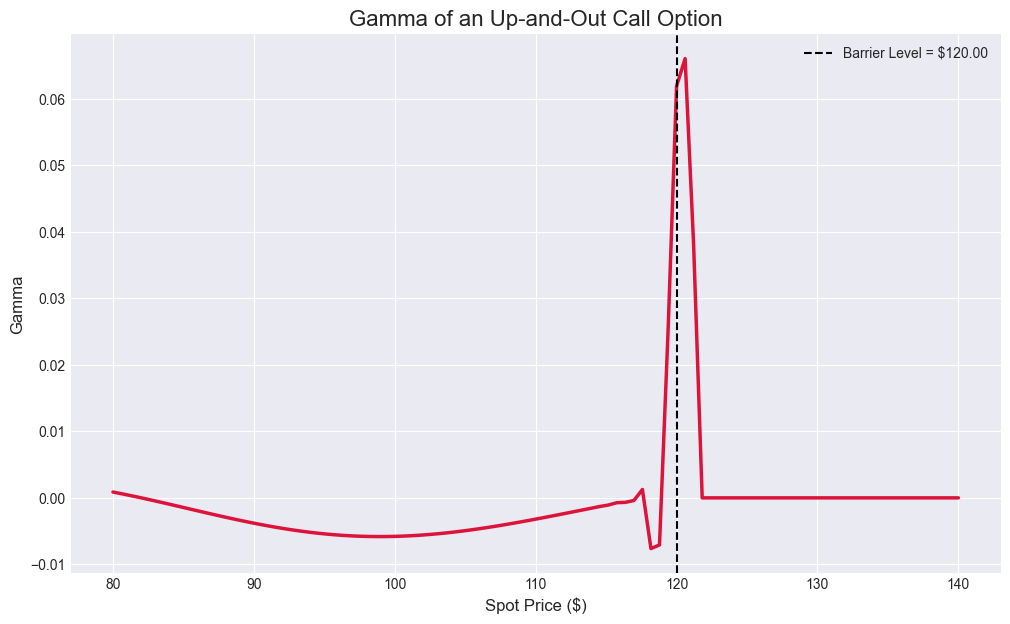

In [8]:
# 1. Define a wider range of spot prices for plotting
spot_prices = np.linspace(80, 140, 100)
gammas = []

# 2. Use the robust FDEngine for this calculation
fd_engine_greeks = FDEngine(num_asset_steps=400, num_time_steps=400, s_max_factor=2.5)

# 3. Calculate Gamma for each spot price
for s0_val in spot_prices:
    process = GeometricBrownianMotionProcess(s0=s0_val, r=r, sigma=sigma)
    _, _, gamma = fd_engine_greeks.calculate(barrier_option, process)
    gammas.append(gamma)

# 4. Plot the results
plt.figure(figsize=(12, 7))
plt.plot(spot_prices, gammas, color='crimson', lw=2.5)
plt.axvline(x=120, color='black', linestyle='--', label='Barrier Level = $120.00')
plt.title('Gamma of an Up-and-Out Call Option', fontsize=16)
plt.xlabel('Spot Price ($)', fontsize=12)
plt.ylabel('Gamma', fontsize=12)
plt.legend()
plt.show()

The plot perfectly captures the theoretical Gamma profile: a dramatic spike just before the barrier and an immediate collapse to zero at and beyond the barrier. This confirms our engine is modeling the complex risk dynamics correctly.

## Part IV: Conclusion, Limitations, and Future Enhancements

This project has successfully delivered a modular, validated, and extensible pricing engine for exotic derivatives in Python.

### 9.2 Discussion of Model Limitations

A crucial part of any quantitative project is to acknowledge its limitations. The primary simplifying assumption made throughout this engine is its reliance on the **Geometric Brownian Motion (GBM)** model. The key limitations of this model are:

1.  **Constant Volatility**: The model assumes the volatility (σ) of the underlying asset is constant. In reality, volatility changes over time and is dependent on the asset's price and the option's strike (a phenomenon known as the "volatility smile"). This is the most significant limitation.

2.  **No Jumps**: GBM models continuous asset price movements. It does not account for sudden, discontinuous jumps that can occur in markets due to unexpected news or events.

3.  **Lognormal Distribution**: The model implies that asset returns are normally distributed (and prices are log-normally distributed). Empirical evidence shows that real-world returns often exhibit "fat tails," meaning extreme events are more likely than the normal distribution predicts.

### 9.3 Roadmap for Future Enhancements

The modular architecture of the engine makes it an excellent platform for future extensions. Potential enhancements to address the limitations include:

1.  **Implementing Advanced Stochastic Processes**: The `models` module could be extended to include more realistic processes:
    * **Heston Model**: To capture stochastic (non-constant) volatility.
    * **Merton's Jump-Diffusion Model**: To incorporate market shocks and jumps.

2.  **Supporting Multi-Asset Options**: The engine's architecture could be expanded to price options whose payoffs depend on multiple underlying assets (e.g., basket options, rainbow options). This would primarily involve updating the `MonteCarloEngine` to handle correlated asset price simulations.

3.  **Integrating Machine Learning Techniques**: Explore the use of machine learning for tasks such as:
    * **Model Calibration**: Using neural networks to quickly calibrate complex models like Heston to the market's implied volatility surface.
    * **Fast Pricing Proxies**: Training a model to learn the pricing function, allowing for near-instantaneous pricing once the model is trained.